# Using CRISP-DM for solving the Seattle AirBnB Dataset

# Business Understanding

Before AirBnB, it would have been a nerve wracking prospect to let strangers stay in your home. But now day by day, the popularity of AirBnB and other vacation homes is rising. They become a Profitable investment to many Investors.
The company has changed the relationship between the house-owner and the renter. Most of us are familiar with the experience as guests, but today I’ll be answering the questions from the Investor’s or Stakeholder’s point of view.

The following Questions were answered in the Blog:

- In which Season of the Year, the occupancy is more ?
- How much the Prices change per month ?
- What are the top favorite Neighborhoods in Seattle ?
- What are the key Factors that influence the Price of an AirBnB ?
- How the AirBnBs are distributed in the city ?

# Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

In [2]:
calendar = pd.read_csv('./data/calendar.csv', parse_dates=['date'])
listings = pd.read_csv('./data/listings.csv')
reviews = pd.read_csv('./data/reviews.csv' , parse_dates=['date'])

In [3]:
# Selecting the list_id and date from the reviews data
reviews = reviews[['listing_id', 'date']]

In [4]:
# Selecting the list_id, price and date from the reviews data
calendar = calendar[['listing_id', 'date', 'price']]

In [5]:
# Reviews Data has 84849 rows and 2 columns
reviews.shape

(84849, 2)

In [6]:
# Calender Data has 1393570 rows and 3 columns
calendar.shape

(1393570, 3)

In [7]:
# Choosing the required columns
listings_df = listings[['neighbourhood', 'city', 'state']]
listings_df.head()

,neighbourhood,city,state
0,Queen Anne,Seattle,WA
1,Queen Anne,Seattle,WA
2,Queen Anne,Seattle,WA
3,Queen Anne,Seattle,WA
4,Queen Anne,Seattle,WA


In [8]:
# All the cities in the dataset
listings_df['city'].value_counts()

Seattle                  3810
Seattle                     2
West Seattle                2
Phinney Ridge Seattle       1
西雅图                         1
seattle                     1
Ballard, Seattle            1
Name: city, dtype: int64

There is one strange value to be removed here

In [9]:
listings_df['state'].value_counts()

WA    3817
wa       1
Name: state, dtype: int64

In [10]:
# For No of Reservations 
freq_count = reviews['date'].value_counts().values
# For Index
freq_index = reviews['date'].value_counts().index

# Combining into a Dataframe
frequency = pd.DataFrame(freq_count,index=freq_index,columns=['No_of_Reservations'])
# Arrange the Data in the Yearly format
reservation_frequency_annual = frequency.resample('A').sum()
#This Data shows the number of reservations per year from reviews data
display(reservation_frequency_annual)

,No_of_Reservations
2009-12-31,17
2010-12-31,254
2011-12-31,1169
2012-12-31,3251
2013-12-31,7077
2014-12-31,20365
2015-12-31,52493
2016-12-31,223


In [11]:
# For No of Reservations 
count_cal = calendar['date'].value_counts().values
# For Index
index_cal = calendar['date'].value_counts().index

# Combining into a Dataframe
calender_freq = pd.DataFrame(count_cal,index=index_cal, columns=['Records'])
# Arrange the Data in the Yearly format
calender_freq_annual = calender_freq.resample('A').sum()
#This Data shows the number of reservations per year from calendar data
calender_freq_annual

,Records
2016-12-31,1385934
2017-12-31,7636


From the above Study we can observe that :

- The information in the reviews dataset has been recorded between 2009 and 2016. 
- The information in the calendar dataset has been recorded between 2016 and 2017.
- In the Reviews dataset, the maximum number of records can be seen in the year 2015.
- In the calender dataset, the maximum number of records can be seen in the year 2016.

Hence, I will use the **year 2015** for analyisis of the most number of occupancies of the year and **year 2016** to study price vartion during the year

# Prepare Data

## -- For 1st Question -- 

In [12]:
def get_data1(reviews):

    # For No of Reservations 
    freq_count = reviews['date'].value_counts().values
    # For Index
    freq_index = reviews['date'].value_counts().index

    # Combining into a Dataframe
    frequency = pd.DataFrame(freq_count,index=freq_index,columns=['No_of_Reservations'])
    # Arrange the Data in the Yearly format
    reservation_frequency_annual = frequency.resample('A').sum()
    #This Data shows the number of reservations per year from reviews data
    display(reservation_frequency_annual)

    # Select the year 2015 from the Data
    reservation_frequency_2015 = frequency.loc['2015']

    # Sum of the Reservations by Month
    reservation_2015_month = reservation_frequency_2015.resample('M').sum()

    #Calculating the percentage reservations in 2015 for every month
    reservation_2015_month['% Reservations'] = reservation_2015_month['No_of_Reservations']*100/reservation_2015_month["No_of_Reservations"].sum()

    #This data has No_of_Reservations and percent share of reservations for every month in 2015
    display(reservation_2015_month) 
    
    return reservation_2015_month

## -- For 2nd Question -- 

In [13]:
def get_data2(calendar):
    # Set the date to index
    calendar.index = calendar['date']

    # Get the data for year 2016
    data_2016 = calendar.loc['2016']

    # Calculating the Percentage of Missing Values
    print(data_2016.isnull().mean())

    # Dropping Null values
    data_2016_dropna = data_2016.dropna()

    # Clean the Price Column
    data_2016_dropna['price'] = data_2016_dropna['price'].apply(lambda x: float(x[1:].replace(',', '')))
    data_2016_dropna = data_2016_dropna[['price']]

    data_2016_dropna.head()

    # Resemple data by month
    data_2016_month = data_2016_dropna.resample('M').mean()
    # difference between the price mean per month and the price mean
    data_2016_month['Difference'] = data_2016_month['price'] - data_2016_month['price'].mean()

    # Print data
    return data_2016_month

# --- for 3rd question ---

In [14]:
def get_data3(listings):
    listings_df = listings[['neighbourhood', 'city', 'state']]
    display(listings_df.head())
    listings_df = listings_df[listings_df.city != '西雅图']
    neighbour_count = listings_df['neighbourhood'].value_counts()
    df = pd.DataFrame({'neighbourhood': neighbour_count.index[:10],'Request_Percent': 100*neighbour_count.iloc[:10].values/neighbour_count.sum()})
    display(df.head(10))
    return df

# --- for 4th question ---

In [15]:
def clean_data4(listings):
    
    feature_data = listings[['neighbourhood_group_cleansed','property_type','room_type','accommodates','bathrooms','bedrooms','price']]
    
    # Imputation of Nulls with the Median value
    # Reason behind choosing median over mean is that the mean was in a decimals e.g: 2.6, 3.5
    #  but the median value comes in the whole number eg: 5.0, 6.0 
    feature_data.bathrooms.fillna(feature_data.bathrooms.median(),inplace = True)
    feature_data.bedrooms.fillna(feature_data.bedrooms.median(), inplace = True)
    
    # Imputation of Nulls with the Mode value
    # For Categorical datatypes imputation is done with Mode value
    feature_data.property_type.fillna(feature_data.property_type.mode(),inplace = True)
    
    # Normalising the accommodates, bathrooms, bedrooms columns 
    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler()
    
    feature_data['accommodates'] = min_max_scaler.fit_transform(feature_data[['accommodates']])
    feature_data['bathrooms'] = min_max_scaler.fit_transform(feature_data[['bathrooms']])
    feature_data['bedrooms'] = min_max_scaler.fit_transform(feature_data[['bedrooms']])
    
    # Clean the Special characters
    feature_data['price'] = feature_data['price'].apply(lambda x: float(x[1:].replace(',', '')))
    
    # Make Dummy variables for categorical columns
    feature_data = pd.get_dummies(feature_data, columns=['neighbourhood_group_cleansed','property_type','room_type'])
    
    return feature_data

# --- for 5th Question ---

 Not Required as the Latitude and Longitude columns don't have Nulls

# 1. In which Season of the Year, the occupancy is more ?

In [16]:
reservation_2015_month = get_data1(reviews)

,No_of_Reservations
2009-12-31,17
2010-12-31,254
2011-12-31,1169
2012-12-31,3251
2013-12-31,7077
2014-12-31,20365
2015-12-31,52493
2016-12-31,223


,No_of_Reservations,% Reservations
2015-01-31,1717,3.270912
2015-02-28,1662,3.166136
2015-03-31,2682,5.109253
2015-04-30,2700,5.143543
2015-05-31,3770,7.181910
2015-06-30,5549,10.570933
2015-07-31,6580,12.535005
2015-08-31,7963,15.169642
2015-09-30,6985,13.306536
2015-10-31,5536,10.546168


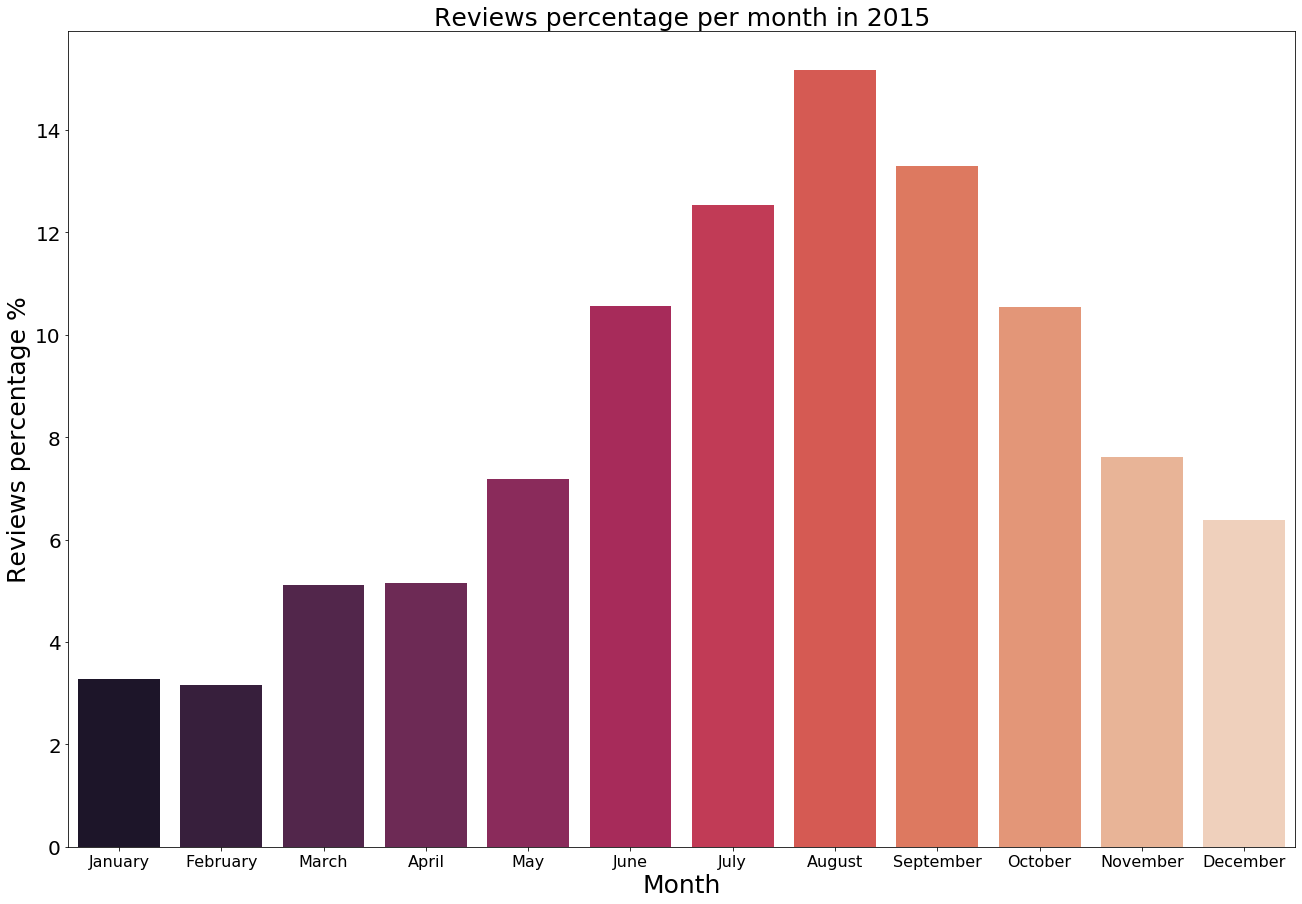

In [17]:
# Bar plot of Month vs Reviews percentage
plot = plt.figure(figsize=(22, 15))
axis = plot.add_subplot(1, 1, 1, aspect='auto')
sns.barplot(x=reservation_2015_month.index.month_name(), y=reservation_2015_month['% Reservations'], palette="rocket")

# Set Labels for the Plot
axis.set_xlabel('Month', weight='normal', size=25)
axis.set_ylabel('Reviews percentage %', weight='normal', size=25)
plt.title('Reviews percentage per month in 2015', fontsize=25)
axis.tick_params('x', labelsize=16)
axis.tick_params('y', labelsize=20)

plt.show()

From the above graph we can conclude that
- the August month has the highest Engagement of Customers which shows that the Occupancy is the highest in August as compared to the rest of the year.
- Next, the lowest occupancy is in February where the AirBnBs aren’t used by people in Seattle.
- We can also conclude that the summers have most occupancy. It may be because people go to vacations more.

# 2. How much the Prices change per month ?

In [18]:
data_2016_month = get_data2(calendar)

listing_id    0.000000
date          0.000000
price         0.329806
dtype: float64


D:\Installs\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


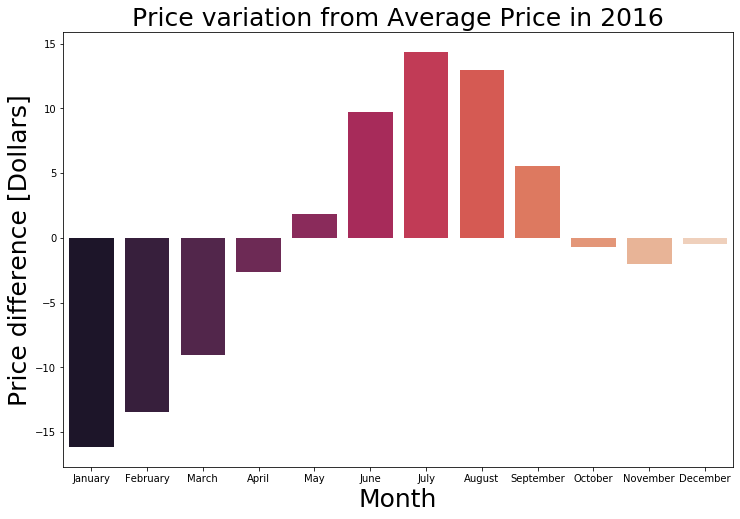

In [19]:
# Plot the Price Difference vs Months
fig2 = plt.figure(figsize=(12, 8))
ax = fig2.add_subplot(1, 1, 1, aspect='auto')
sns.barplot(x=data_2016_month.index.month_name(), y=data_2016_month['Difference'], palette="rocket")

# Set the Labels and Axes
ax.set_xlabel('Month', weight='normal', size=25)
ax.set_ylabel('Price difference [Dollars]', weight='normal', size=25)
plt.title('Price variation from Average Price in 2016', fontsize=25)
axis.tick_params('x', labelsize=25)
axis.tick_params('y', labelsize=25)

plt.show()

From the above graph, we understand that :

- From the months of May to September the Price of Airbnb is generally higher than the Average Price.
- From the months of January to April the Price of Airbnb is lower than the Average Price.
- January has the cheapest Price
- July has the Highest Price

# 3. What are the top favorite Neighborhoods in Seattle ?

In [20]:
df = get_data3(listings)

,neighbourhood,city,state
0,Queen Anne,Seattle,WA
1,Queen Anne,Seattle,WA
2,Queen Anne,Seattle,WA
3,Queen Anne,Seattle,WA
4,Queen Anne,Seattle,WA


,neighbourhood,Request_Percent
0,Capitol Hill,10.317460
1,Ballard,6.261023
2,Belltown,5.996473
3,Minor,5.643739
4,Queen Anne,5.496767
5,Fremont,4.350382
6,Wallingford,4.203410
7,University District,3.145209
8,First Hill,3.086420
9,Stevens,2.880658


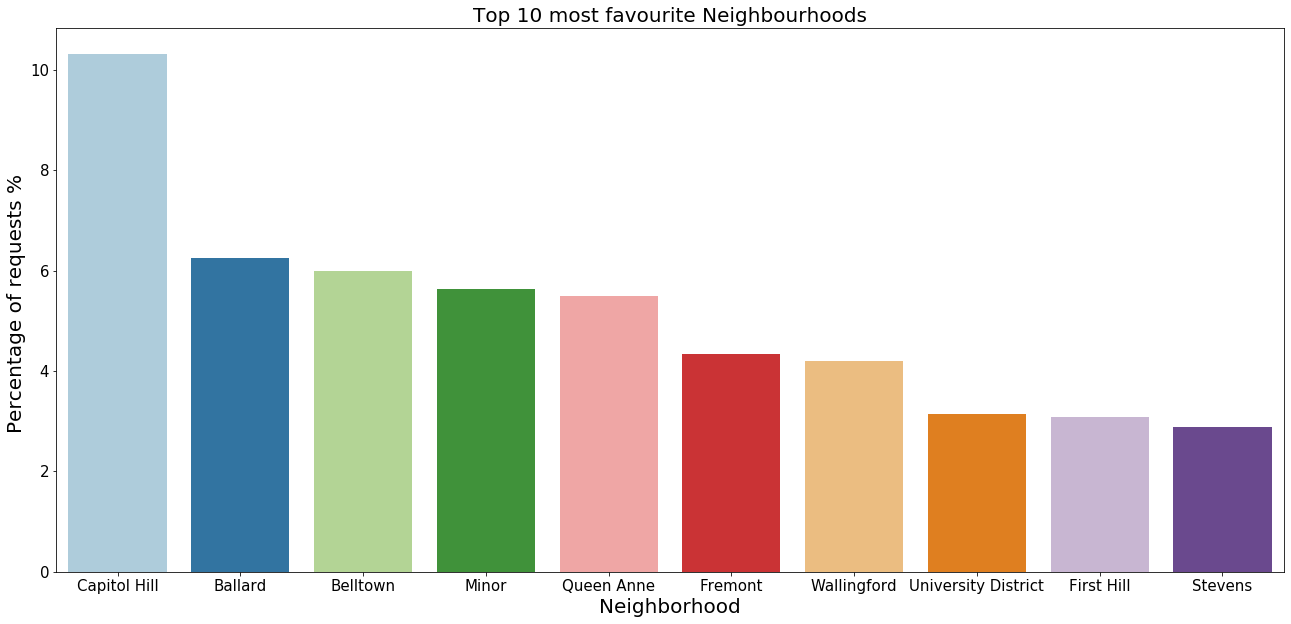

In [21]:
# Plotting the Top 10 favourite Neighbourhoods
fig = plt.figure(figsize=(22, 10))
ax = fig.add_subplot(1, 1, 1, aspect='auto')
sns.barplot(x=df.neighbourhood, y=df['Request_Percent'], palette= "Paired")

# Set axis label properties
ax.set_xlabel('Neighborhood', weight='normal', size=20)
ax.set_ylabel('Percentage of requests % ', weight='normal', size=20)
plt.title('Top 10 most favourite Neighbourhoods', fontsize=20)
# Set tick label properties
ax.tick_params('x', labelsize=15)
ax.tick_params('y', labelsize=15)
plt.show()

From the Above Analysis we conclude that :
- Capitol Hill is the most favourite nieghbourhood in Seattle which has the **10%** of all the requests.
- Ballard and Belltown are also popular among the Customers.

# Data Modeling

In [22]:
feature_data = clean_data4(listings)

D:\Installs\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
D:\Installs\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Installs\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [23]:
feature_data

,accommodates,bathrooms,bedrooms,price,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,...,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0.200000,0.1250,0.142857,85.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.200000,0.1250,0.142857,150.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.666667,0.5625,0.714286,975.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0.133333,0.1250,0.000000,100.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.333333,0.2500,0.428571,450.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0.333333,0.2500,0.428571,359.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3814,0.200000,0.1250,0.142857,79.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3815,0.066667,0.1250,0.142857,93.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3816,0.066667,0.1250,0.000000,99.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [24]:
import pandas as pd
# Splitting the data 
X = feature_data.drop(['price'],axis=1)
y = feature_data['price']

# train and test - x and y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# linear regression model building
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

pred = lm.predict(X_test)

In [25]:
def importance_df(feature_data):
    '''
    This function gives the Importance with Feature Names
    '''
    import pandas as pd
    # Splitting the data 
    X = feature_data.drop(['price'],axis=1)
    y = feature_data['price']
    
    # train and test - x and y
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

    # linear regression model building
    from sklearn.linear_model import LinearRegression
    lm = LinearRegression()
    lm.fit(X_train, y_train)

    # taking the importance of features and column names and sorting into a data frame
    coefficients = pd.DataFrame({'Feature': X_train.columns, 'Importance': lm.coef_})
    plot_data = coefficients.sort_values('Importance', ascending=False)[:15]

    return plot_data

# Evaluate the Results

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [27]:
print("Mean Squared Error: {}".format(mean_squared_error(y_test, pred)) )
print("Mean Absoulte Error: {}".format(mean_absolute_error(y_test, pred)) )
print("R2 Score: {}".format(r2_score(y_test, pred)) )

Mean Squared Error: 3442.4887813296405
Mean Absoulte Error: 36.26287645428383
R2 Score: 0.5758551686160358


- From the results we conclude that Mean Squared Error: 3442.48, Mean Absoulte Error: 36.26 and R2 Score: 0.575 are the final results of the model.
- However, the reuslts can be Improved by using XGBoost, Light GBM, CatBoost Regressors.
- Hyperparameter tuning may also improve the scores.

In [28]:
# Top 10 feature importance
importance_df = importance_df(feature_data)
importance_df

,Feature,Importance
2,bedrooms,230.951062
1,bathrooms,223.645553
22,property_type_Boat,189.007750
0,accommodates,139.553904
25,property_type_Camper/RV,80.845868
34,property_type_Treehouse,48.761797
30,property_type_Loft,43.643104
9,neighbourhood_group_cleansed_Downtown,38.081060
36,room_type_Entire home/apt,34.672836
35,property_type_Yurt,32.235656


# 4. What are the key Factors that influence the Price of an Airbnb ?

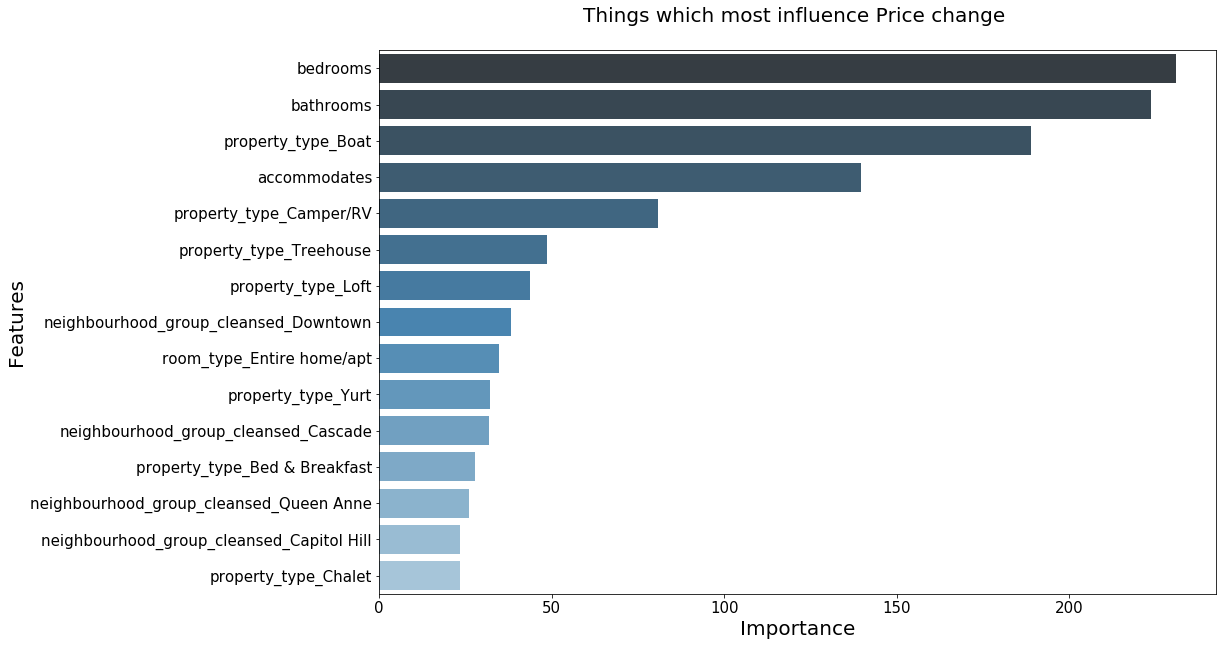

In [29]:
# Plotting features with Importance
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, aspect='auto')
sns.barplot(y=importance_df['Feature'], x=importance_df['Importance'], palette= "Blues_d")

# Set axis label properties
ax.set_xlabel('Importance', weight='normal', size=20)
ax.set_ylabel('Features', weight='normal', size=20)
plt.title('Things which most influence Price change \n', fontsize=20)
# Set tick label properties
ax.tick_params('x', labelsize=15)
ax.tick_params('y', labelsize=15)
plt.show()

Above graph shows that :
- Bedrooms and Bathrooms have high importance in influencing price, meaning more Number of Bedrooms in an AirBnB more is the Price of the Stay.
- Boat Properties also have more impact followed by Camping Properties.

# 5. How the AirBnBs are distributed in the city ? 

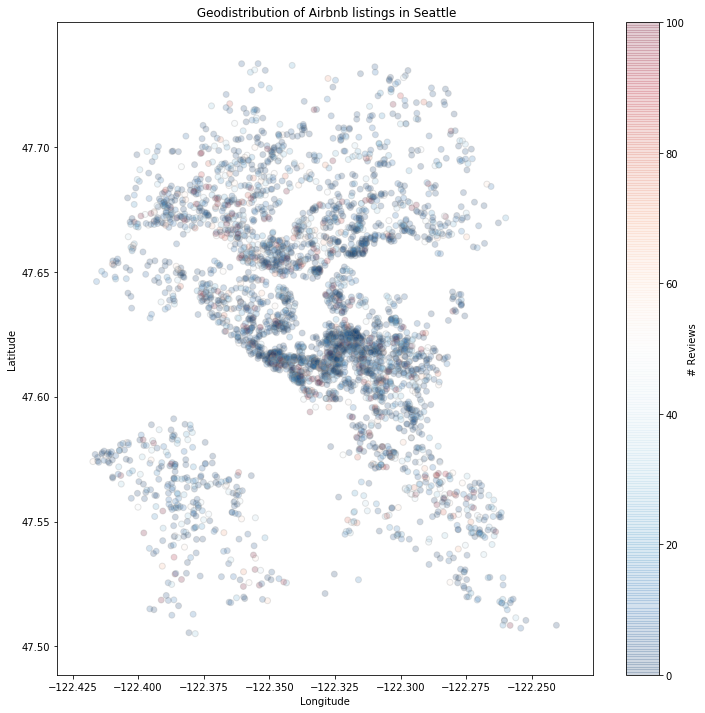

In [30]:
plt.figure(figsize=(12,12))
fig = plt.scatter(data=listings, x='longitude', y='latitude', alpha=0.2, c='number_of_reviews', cmap=plt.cm.RdBu_r, vmin=0, vmax=100, edgecolors='gray',animated=True)

cbar = plt.colorbar(fig)
cbar.set_label('# Reviews')
plt.xticks()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(' Geodistribution of Airbnb listings in Seattle');

From the above two figures we can conclude that :
- The city center of the Seattle is most crowded with the AirBnBs, therefore you can expect more competition !
- The Lake View AirBnBs are also a good destination for Investing.
- The Country side AirBnBs are seen to have higher Number of Reviews which may for Vacations.